## Imports

In [1]:
import torch
import torch.nn.parallel
import torch.utils
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
import time
from PIL import Image
import DrawingWithTensors
import math
import os
import sys

#original basis of code for training: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
import argparse

# initialize the parser
parser = argparse.ArgumentParser(description = "List of options to run application when creating custom datset")

parser = argparse.ArgumentParser()  
parser.add_argument("-V", "--version", help="show program version", action="store_true")
parser.add_argument("-b", "--batch", help="batch size in each epoch")
parser.add_argument("-e", "--epoch", help="number of epochs for training")
parser.add_argument("-r", "--root_folder", help="destination for root folder")
parser.add_argument("-i", "--iteration", help="which generation number we are using")
parser.add_argument("-t", "--training", help="true/false to start with new Unet weights")
parser.add_argument("-w", "--weights", help="full path to save weights")
parser.add_argument("-c", "--pickup", help="full path to resume training use weights")
parser.add_argument("-p", "--picture", help="picture dimensions")
parser.add_argument("-d", "--dataset", help="root directory of dataset folder")

_StoreAction(option_strings=['-d', '--dataset'], dest='dataset', nargs=None, const=None, default=None, type=None, choices=None, help='root directory of dataset folder', metavar=None)

In [3]:
NUM_CLASSES = 1
EPOCHS = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
imageSize = 416
batchSize = 1
iteration = "1"
newTraining = False

#change values if user specifies non-default values
args = parser.parse_args(['-t','false',
                          '-i','9',
                          '-e','1000',
                          '-b','3',
                          '-c','/home/peo5032/Documents/COMP594/logged_weights/modelBetterBackgroundBCE',
                          '-w', '/home/peo5032/Documents/COMP594/modelBetterBackgroundv1-1K-DICE.pt', 
                          '-p','416'])
# check for --version or -V
if args.version:  
    print("this is version 0.1")
    
if args.batch: 
    print("batch size is set to", args.batch)
    batchSize = int(args.batch)

if args.epoch: 
    print("number of epochs is set to", args.epoch)
    EPOCHS = int(args.epoch)
    
if args.root_folder:  
    if os.path.exists(root_folder):
        ROOT = root_folder
    print("destination was", args.root_folder)
    
if args.iteration:
    print("iteration is set to", args.iteration)
    iteration = args.iteration

    
SAVE_LOCATION = "/home/peo5032/Documents/COMP594/input/gen"+iteration+"/model.pt"

if args.weights:
    print("save location is set to", args.weights)
    SAVE_LOCATION = args.weights
    
    
LOAD_LOCATION = "/home/peo5032/Documents/COMP594/input/gen"+iteration+"/model.pt"


if args.pickup:
    print("load location is set to", args.pickup)
    LOAD_LOCATION = args.pickup

    
data_dir = '/home/peo5032/Documents/COMP594/input/gen'+iteration

if args.dataset:
    print("loading dataset from ", args.dataset)
    data_dir = args.dataset
    
if args.training:
    if args.training.lower() == "true":
        print("new training is set to true")
        newTraining = True
        
if args.picture:
    print("picture size to train on is", args.picture)
    imageSize = int(args.picture)

batch size is set to 3
number of epochs is set to 1000
iteration is set to 9
save location is set to /home/peo5032/Documents/COMP594/modelBetterBackgroundv1-1K-DICE.pt
load location is set to /home/peo5032/Documents/COMP594/logged_weights/modelBetterBackgroundBCE
picture size to train on is 416


In [4]:
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
class DICELossMultiClass(torch.nn.Module):
 
    def __init__(self):
        super(DICELossMultiClass, self).__init__()
    
    #https://gist.github.com/weiliu620/52d140b22685cf9552da4899e2160183#file-dice_coeff_loss-py-L3
    def forward(self, pred, target):
        """This definition generalize to real valued pred and target vector.
            This should be differentiable.
            pred: tensor with first dimension as batch
            target: tensor with first dimension as batch
        """
        pred = torch.sigmoid(pred)
        #if(torch.equal(pred,torch.ones(1,1,416,416).to(device))):
        #    print("PROBLEM, ALL ONES?")

        intersection = (pred*target).sum()
        
        A_sum = torch.sum(pred)
        #print("A_SUM:",A_sum.item())
        B_sum = torch.sum(target)
        #print("B_SUM:",B_sum.item())
        union = (A_sum + B_sum)
        
        #print("top:",(2. * intersection).item(),"bottom:",union.item())
        return 1 - ((2. * intersection) / union.float())
    
    #https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c
    def dice_loss(input, target):
        input = torch.sigmoid(input)
        smooth = 1.

        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2. * intersection + smooth) /
                  (iflat.sum() + tflat.sum() + smooth))

In [6]:
class IOU_BCELoss(torch.nn.Module):
    
    def _init_(self):
        super(IOU_BCELoss,self)._init_()
    
    def forward(self, pred, target):
        """This definition is used from the TernausNet loss, using both IoU and BCE.
        This should be differentiable.
        pred: tensor with first dimension as batch, without sigmoid
        target: tensor with first dimension as batch
        """
        pred = torch.sigmoid(pred)
        
        H = torch.nn.BCELoss()(pred,target)
        #print("BCELoss:",H.item())
        
        Aflat = pred.contiguous().view(-1)
        Bflat = target.contiguous().view(-1)
        
        intersection = (Aflat * Bflat).sum()
        #print("intersection:", intersection.item())
        
        Asum = pred.sum()
        Bsum = target.sum()
        
        bottom = Asum + Bsum - intersection
        #print("union:", bottom.item())
        
        J = intersection/(bottom)
        #print("J:", J)
        
        logJ = torch.log(J)    
        #print("logJ:",logJ)
        
        return H - logJ

## Load Data

In [7]:
data_transforms = transforms.Compose([transforms.Resize([imageSize,imageSize]),
                                      transforms.ToTensor()
                                     ])

# instantiate the dataset and dataloader
dataset = ImageFolderWithPaths(data_dir, transform=data_transforms) # our custom dataset
dataloaders = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle=True)

# iterate over data
#for inputs, labels, paths in dataloader:
#    # use the above variables freely
#    print(inputs, labels, paths)

#groundTruth = tensor
#label = tensor[0,0]
#path = tuple list, access each via path[index]

new_road_factory = DrawingWithTensors.datasetFactory(IMAGE_SIZE=416)

## Training Routine without Validation Steps

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=4):
    since = time.time()
    best_model = None
    best_loss = math.inf
    model.train()  # Set model to training mode
    for epoch in range(1,num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1), flush=True)
        epoch_loss = 0
   
        #BATCH TUPLE
        inputs, labels, paths = next(iter(dataloaders))
        inputs.to(device)
        #print(inputs.size())
                
        #build ground-truth batch tensor
        for locations in paths:
            i = 0
            #dtype=torch.int64
            labels = torch.zeros(batchSize,NUM_CLASSES,imageSize,imageSize, dtype = torch.float32).to(device)
            labels[i] = torch.load(locations.replace(".png", ".pt").replace("roads", "tensor_values")) #manually fetch your own tensor values here somehow? 
            i += 1
            
        # forward
        # track history if only in train
        # TODO: ENSURE OUTPUTS AND GROUNDTRUTH ARE THE SAME
        with torch.set_grad_enabled(True):
            #build input-truth batch tensor
            outputs = model(inputs.to(device)).to(device)
            loss = criterion(outputs, labels) #ground truth comparison

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # backward + optimize 
            loss.backward()
            optimizer.step()
            
            # statistics
            epoch_loss += loss.item()
            
            #scheduler.step()
        
        #print('Epoch finished', flush=True)
        #print("BCE: {}".format(epoch_loss), flush=True)
        print("loss: {}".format(epoch_loss), flush=True)
        print('---------------', flush=True)
        #save best copy of  model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model, SAVE_LOCATION.replace("model", "model_best"))
        
    time_elapsed = time.time() - since
    
    print('Training complete in {:.1f}m {:.1f}s'.format(time_elapsed // 60, time_elapsed % 60), flush=True)

    #completed model
    torch.save(model,SAVE_LOCATION)
    return model

In [9]:
def showInferenceOnImage(img, tensor, class_label, threshold, classMap):
    IMAGE_SIZE = 416
    imgTMP = img.copy()
    imgMap = imgTMP.load()
    class_type_corresponding_channel = classMap[class_label]
    print("index for channel", class_label, ":", class_type_corresponding_channel)    
    for i in range(0, IMAGE_SIZE):
        for j in range(0, IMAGE_SIZE):
            if tensor[class_type_corresponding_channel, i,j] < threshold:
                #hide background and emphasize the places where the network thinks are "class type"
                imgMap[i,j] = (0,0,0)
        
    return imgTMP

## Load Pretrained Model Weights

In [10]:
from unet_models import *

#imports related to UNet
if newTraining:
    model = UNet16(num_classes=1, num_filters=32,pretrained=True, is_deconv=True)
    
    print('initializing model with random weights')
    torch.nn.init.xavier_uniform_(next(model.center.children())[1].weight)
    #torch.nn.init.xavier_uniform_(next(model.center.children())[1].bias)
    
    torch.nn.init.xavier_uniform_(next(model.dec5.children())[1].weight)
    
    torch.nn.init.xavier_uniform_(next(model.dec4.children())[1].weight)

    torch.nn.init.xavier_uniform_(next(model.dec3.children())[1].weight)

    torch.nn.init.xavier_uniform_(next(model.dec2.children())[1].weight)

    torch.nn.init.xavier_uniform_(next(model.dec1.children()).weight)

    torch.nn.init.xavier_uniform_(model.final.weight)
                           
else:
    print("loading weights from", LOAD_LOCATION)
    model = torch.load(LOAD_LOCATION)

model = model.to(device)

loading weights from /home/peo5032/Documents/COMP594/logged_weights/modelBetterBackgroundBCE


## Training and Results

In [11]:
#criterion = torch.nn.BCEWithLogitsLoss()
criterion = DICELossMultiClass()
#criterion = IOU_BCELoss()

# Observe default choices, except using amsgrad version of Adam
optimizer_ft = optim.Adam(model.parameters(), lr=0.01, weight_decay=0, amsgrad=False, eps=0.1)

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model.parameters(), lr=0.2, momentum=0.90)
# Osscilate between high and low learning rates
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=EPOCHS,eta_min=0.001)

try:
    model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=EPOCHS)

except KeyboardInterrupt:
    torch.save(model, SAVE_LOCATION.replace("model",'INTERRUPTED'))
    print('Saved interrupt', flush=True)

Epoch 1/999
loss: 0.7899748086929321
---------------
Epoch 2/999
loss: 0.7875569462776184
---------------
Epoch 3/999
loss: 0.7897186875343323
---------------
Epoch 4/999
loss: 0.7882755994796753
---------------
Epoch 5/999
loss: 0.8124634623527527
---------------
Epoch 6/999
loss: 0.7852148413658142
---------------
Epoch 7/999
loss: 0.7905782461166382
---------------
Epoch 8/999
loss: 0.9372793436050415
---------------
Epoch 9/999
loss: 0.8183783292770386
---------------
Epoch 10/999
loss: 0.7827500104904175
---------------
Epoch 11/999
loss: 0.789828360080719
---------------
Epoch 12/999
loss: 0.7786931991577148
---------------
Epoch 13/999
loss: 0.8455799221992493
---------------
Epoch 14/999
loss: 0.7738744616508484
---------------
Epoch 15/999
loss: 0.7944303750991821
---------------
Epoch 16/999
loss: 0.787276566028595
---------------
Epoch 17/999
loss: 0.7774388790130615
---------------
Epoch 18/999
loss: 0.7723842263221741
---------------
Epoch 19/999
loss: 0.7723283767700195
-

loss: 0.6260455846786499
---------------
Epoch 153/999
loss: 0.6375125646591187
---------------
Epoch 154/999
loss: 0.6265991926193237
---------------
Epoch 155/999
loss: 0.8541818261146545
---------------
Epoch 156/999
loss: 0.6332370042800903
---------------
Epoch 157/999
loss: 0.6542066335678101
---------------
Epoch 158/999
loss: 0.6971518993377686
---------------
Epoch 159/999
loss: 0.6262151002883911
---------------
Epoch 160/999
loss: 0.6956827044487
---------------
Epoch 161/999
loss: 0.7504492402076721
---------------
Epoch 162/999
loss: 0.6413482427597046
---------------
Epoch 163/999
loss: 0.6896227598190308
---------------
Epoch 164/999
loss: 0.644845724105835
---------------
Epoch 165/999
loss: 0.6938538551330566
---------------
Epoch 166/999
loss: 0.6353168487548828
---------------
Epoch 167/999
loss: 0.6362935900688171
---------------
Epoch 168/999
loss: 0.6883881092071533
---------------
Epoch 169/999
loss: 0.8409122228622437
---------------
Epoch 170/999
loss: 0.655222

Epoch 302/999
loss: 0.6528005599975586
---------------
Epoch 303/999
loss: 0.8537390828132629
---------------
Epoch 304/999
loss: 0.6226695775985718
---------------
Epoch 305/999
loss: 0.6921517848968506
---------------
Epoch 306/999
loss: 0.6541208028793335
---------------
Epoch 307/999
loss: 0.6245388984680176
---------------
Epoch 308/999
loss: 0.6619694232940674
---------------
Epoch 309/999
loss: 0.6749041676521301
---------------
Epoch 310/999
loss: 0.6876729726791382
---------------
Epoch 311/999
loss: 0.6465116739273071
---------------
Epoch 312/999
loss: 0.7669304609298706
---------------
Epoch 313/999
loss: 0.6481456756591797
---------------
Epoch 314/999
loss: 0.6184380054473877
---------------
Epoch 315/999
loss: 0.6409655809402466
---------------
Epoch 316/999
loss: 0.6496430039405823
---------------
Epoch 317/999
loss: 0.6509355306625366
---------------
Epoch 318/999
loss: 0.6307955980300903
---------------
Epoch 319/999
loss: 0.7499810457229614
---------------
Epoch 320/

loss: 0.5697014331817627
---------------
Epoch 452/999
loss: 0.690865159034729
---------------
Epoch 453/999
loss: 0.7077398300170898
---------------
Epoch 454/999
loss: 0.7610132098197937
---------------
Epoch 455/999
loss: 0.7264789342880249
---------------
Epoch 456/999
loss: 0.6106125116348267
---------------
Epoch 457/999
loss: 0.8094517588615417
---------------
Epoch 458/999
loss: 0.7127604484558105
---------------
Epoch 459/999
loss: 0.7560043334960938
---------------
Epoch 460/999
loss: 0.7623554468154907
---------------
Epoch 461/999
loss: 0.5843563079833984
---------------
Epoch 462/999
loss: 0.602127194404602
---------------
Epoch 463/999
loss: 0.7298831343650818
---------------
Epoch 464/999
loss: 0.5699014067649841
---------------
Epoch 465/999
loss: 0.7350999116897583
---------------
Epoch 466/999
loss: 0.658944845199585
---------------
Epoch 467/999
loss: 0.7455742359161377
---------------
Epoch 468/999
loss: 0.7892476916313171
---------------
Epoch 469/999
loss: 0.78401

---------------
Epoch 601/999
loss: 0.6772122383117676
---------------
Epoch 602/999
loss: 0.6251164674758911
---------------
Epoch 603/999
loss: 0.6452450752258301
---------------
Epoch 604/999
loss: 0.6322450637817383
---------------
Epoch 605/999
loss: 0.693246603012085
---------------
Epoch 606/999
loss: 0.6569288969039917
---------------
Epoch 607/999
loss: 0.6301748752593994
---------------
Epoch 608/999
loss: 0.7187508344650269
---------------
Epoch 609/999
loss: 0.635367751121521
---------------
Epoch 610/999
loss: 0.7827256917953491
---------------
Epoch 611/999
loss: 0.640887975692749
---------------
Epoch 612/999
loss: 0.6271575093269348
---------------
Epoch 613/999
loss: 0.6221470236778259
---------------
Epoch 614/999
loss: 0.6224731206893921
---------------
Epoch 615/999
loss: 0.7382115125656128
---------------
Epoch 616/999
loss: 0.70204758644104
---------------
Epoch 617/999
loss: 0.6243168115615845
---------------
Epoch 618/999
loss: 0.6543549299240112
---------------

loss: 0.6540273427963257
---------------
Epoch 751/999
loss: 0.5892418026924133
---------------
Epoch 752/999
loss: 0.6444349884986877
---------------
Epoch 753/999
loss: 0.662183403968811
---------------
Epoch 754/999
loss: 0.6129879951477051
---------------
Epoch 755/999
loss: 0.7018030285835266
---------------
Epoch 756/999
loss: 0.7113099098205566
---------------
Epoch 757/999
loss: 0.7546994686126709
---------------
Epoch 758/999
loss: 0.6370912790298462
---------------
Epoch 759/999
loss: 0.6504214406013489
---------------
Epoch 760/999
loss: 0.7320917844772339
---------------
Epoch 761/999
loss: 0.7749019265174866
---------------
Epoch 762/999
loss: 0.847916841506958
---------------
Epoch 763/999
loss: 0.6134432554244995
---------------
Epoch 764/999
loss: 0.7329063415527344
---------------
Epoch 765/999
loss: 0.6317745447158813
---------------
Epoch 766/999
loss: 0.605642557144165
---------------
Epoch 767/999
loss: 0.6093212366104126
---------------
Epoch 768/999
loss: 0.73423

---------------
Epoch 900/999
loss: 0.6871649026870728
---------------
Epoch 901/999
loss: 0.6424441337585449
---------------
Epoch 902/999
loss: 0.5945667028427124
---------------
Epoch 903/999
loss: 0.5984945297241211
---------------
Epoch 904/999
loss: 0.6975758671760559
---------------
Epoch 905/999
loss: 0.6808962821960449
---------------
Epoch 906/999
loss: 0.591742753982544
---------------
Epoch 907/999
loss: 0.7100099325180054
---------------
Epoch 908/999
loss: 0.6147368550300598
---------------
Epoch 909/999
loss: 0.7738845944404602
---------------
Epoch 910/999
loss: 0.6935961842536926
---------------
Epoch 911/999
loss: 0.655499279499054
---------------
Epoch 912/999
loss: 0.7140617370605469
---------------
Epoch 913/999
loss: 0.6772596836090088
---------------
Epoch 914/999
loss: 0.6859471797943115
---------------
Epoch 915/999
loss: 0.6587523221969604
---------------
Epoch 916/999
loss: 0.6473414897918701
---------------
Epoch 917/999
loss: 0.8461059331893921
------------

## Evaluation on Held-Out Training

In [12]:
'''
#Show results in meanwhile
img = Image.open("/home/peo5032/Documents/COMP594/input/gen8/roads/4809.png")
test_tensor = torch.load("/home/peo5032/Documents/COMP594/input/gen8/tensor_values/4809.pt").to(device)
inputs = torch.zeros(1,3, imageSize, imageSize).to(device)

test_tensor.size()
inputs[0] = transforms.ToTensor()(img)
outputs = model(inputs)
'''

'\n#Show results in meanwhile\nimg = Image.open("/home/peo5032/Documents/COMP594/input/gen8/roads/4809.png")\ntest_tensor = torch.load("/home/peo5032/Documents/COMP594/input/gen8/tensor_values/4809.pt").to(device)\ninputs = torch.zeros(1,3, imageSize, imageSize).to(device)\n\ntest_tensor.size()\ninputs[0] = transforms.ToTensor()(img)\noutputs = model(inputs)\n'

In [13]:
#outputs[0][0][15]

In [14]:
#torch.sigmoid(outputs[0][0][0])

In [15]:
#print("min", torch.min(outputs[0][0]), "max", torch.max(outputs[0][0]))

In [16]:
#print("min", torch.min(torch.sigmoid(outputs[0][0])), "max", torch.max(torch.sigmoid(outputs[0][0])))

In [17]:
'''class_label = "road"
threshold = 0.20
classMap = new_road_factory.classMap
showInferenceOnImage(img, torch.sigmoid(outputs[0]), class_label, threshold, classMap)
#showInferenceOnImage(img, test_tensor, class_label, threshold, classMap)
'''

'class_label = "road"\nthreshold = 0.20\nclassMap = new_road_factory.classMap\nshowInferenceOnImage(img, torch.sigmoid(outputs[0]), class_label, threshold, classMap)\n#showInferenceOnImage(img, test_tensor, class_label, threshold, classMap)\n'

## Evaluation on Satellite-Heldout Images

In [39]:
import matplotlib.pyplot as plt
%matplotlib notebook

#Show results in meanwhile
PATH="/home/peo5032/Pictures/evaluationPhotos"
resize = transforms.Resize([imageSize,imageSize])

#no cars, semi-straight in a direction
#2_19.49_b.png 
#2_60.67_i.png
#2_85.77_b.png

#two lane photo
#2_0.94_d_rotated.png
#9_23.14_b.png #one-lane up and down

#more complex photos
#2_9.31_b.png
#82_36_.92_d.png
#303_4.83_i.png
#285_0.55_b.png

img = Image.open(PATH+"/2_85.77_b.png")
img = resize(img)

inputs = torch.zeros(1,3, imageSize, imageSize).to(device)

inputs[0] = transforms.ToTensor()(img)
outputs = model(inputs)

In [41]:
#outputs[0]

In [42]:
#torch.sigmoid(outputs[0][0][1])

In [43]:
print("min", torch.min(torch.sigmoid(outputs[0][0])), "max", torch.max(torch.sigmoid(outputs[0][0])))

min tensor(0., device='cuda:0', grad_fn=<MinBackward1>) max tensor(0.9999, device='cuda:0', grad_fn=<MaxBackward1>)


index for channel road : 0


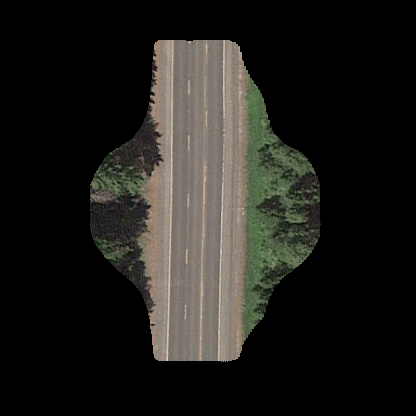

In [44]:
class_label = "road"
threshold = .90
classMap = new_road_factory.classMap
showInferenceOnImage(img, torch.sigmoid(outputs[0]), class_label, threshold, classMap)